<a href="https://colab.research.google.com/github/HymaJoy/ML-DL-APLLICATIONS/blob/main/6_2_Finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
print(tf.__version__)

from tensorflow import keras
tf.random.set_seed(42)

import numpy as np
np.random.seed(42)

import matplotlib.pyplot as plt
%matplotlib inline

2.9.2


#Load the dataset which is already processed

In [3]:
# load numpy array from npy file
from numpy import load

X_train_std = load('/content/drive/MyDrive/Models/X_train_std.npy')
X_test_std = load('/content/drive/MyDrive/Models/X_test_std.npy')

y_train = load('/content/drive/MyDrive/Models/y_train.npy')
y_test = load('/content/drive/MyDrive/Models/y_test.npy')

In [4]:
print("X_train_std_shape: {}".format(X_train_std.shape))
print("X_test_std_shape: {}".format(X_test_std.shape))

X_train_std_shape: (400, 299, 299, 3)
X_test_std_shape: (100, 299, 299, 3)


In [5]:
# Load the saved best model

model_FineTune = keras.models.load_model('/content/drive/MyDrive/Models/01_Xception_TransferLearning_Best_Model.h5')

In [6]:
model_FineTune.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   864         ['input_2[0][0]']                
                                32)                                                               
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, None, None,   128        ['block1_conv1[0][0]']           
 ation)                         32)                                                           

In [7]:
model_FineTune.layers

In [8]:
len(model_FineTune.layers)

134

## Freeze only first 60 layers
- It is a `hyperparameter`

In [9]:
# Fine-tune the model from index 60 onwards

for layer in model_FineTune.layers[:60]:
  layer.trainable = False

for layer in model_FineTune.layers[60:]:
  layer.trainable = True


#Compile and train the model


*  Save the best weights while training




In [10]:
model_FineTune.compile(loss='sparse_categorical_crossentropy', 
                 optimizer='adam', 
                 metrics=['accuracy'])

callbacks_FineTune = [            
             keras.callbacks.ModelCheckpoint("bestFT.h5",
                                             monitor='val_accuracy',
                                             save_weights_only=True,
                                             save_best_only=True)
]

history_FineTune = model_FineTune.fit(x = X_train_std, y = y_train, epochs=50,
                                      validation_split=0.1, batch_size=16, callbacks=callbacks_FineTune)

Epoch 1/50
23/23 [==============================] - 19s 331ms/step - loss: 0.0530 - accuracy: 0.9806 - val_loss: 0.4365 - val_accuracy: 0.9500
Epoch 2/50
23/23 [==============================] - 6s 255ms/step - loss: 0.0349 - accuracy: 0.9917 - val_loss: 1.2189 - val_accuracy: 0.8250
Epoch 3/50
23/23 [==============================] - 6s 258ms/step - loss: 0.0682 - accuracy: 0.9778 - val_loss: 2.4003 - val_accuracy: 0.7250
Epoch 4/50
23/23 [==============================] - 6s 263ms/step - loss: 0.0293 - accuracy: 0.9889 - val_loss: 2.1801 - val_accuracy: 0.7500
Epoch 5/50
23/23 [==============================] - 6s 280ms/step - loss: 0.0253 - accuracy: 0.9944 - val_loss: 3.2016 - val_accuracy: 0.7250
Epoch 6/50
23/23 [==============================] - 6s 271ms/step - loss: 0.0542 - accuracy: 0.9778 - val_loss: 4.3081 - val_accuracy: 0.8500
Epoch 7/50
23/23 [==============================] - 6s 276ms/step - loss: 0.2332 - accuracy: 0.9583 - val_loss: 11.1908 - val_accuracy: 0.5750
Epoc

# Plot accuracy

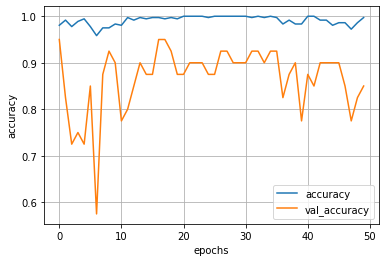

In [11]:
keys = ['accuracy', 'val_accuracy']
progress = {k:v for k,v in history_FineTune.history.items() if k in keys}

import pandas as pd
pd.DataFrame(progress).plot()

plt.xlabel("epochs")
plt.ylabel("accuracy")

plt.grid(True)
plt.show()

## Evaluate the fine-tuned model
- Trained for 50-epochs

In [12]:
testLoss_FineTune, testAccuracy_FineTune = model_FineTune.evaluate(x = X_test_std, y = y_test)
print("Test-loss: %f, Test-accuracy: %f" % (testLoss_FineTune, testAccuracy_FineTune))

4/4 [==============================] - 3s 443ms/step - loss: 0.7491 - accuracy: 0.8400
Test-loss: 0.749129, Test-accuracy: 0.840000


## Update the model with best weights and evaluate
- Saved based on the callback

In [13]:
model_FineTune.load_weights("bestFT.h5")

testLoss_FineTune, testAccuracy_FineTune = model_FineTune.evaluate(x = X_test_std, y = y_test)

print("Test-loss: %f, Test-accuracy: %f" % (testLoss_FineTune, testAccuracy_FineTune))

4/4 [==============================] - 1s 197ms/step - loss: 1.1089 - accuracy: 0.7600
Test-loss: 1.108864, Test-accuracy: 0.760000


#Get the prediction of a single sample

In [15]:
cProba = model_FineTune.predict(X_test_std[:1])

print(cProba)

1/1 [==============================] - 1s 891ms/step
[[1.9917143e-10 3.1462283e-10 9.9999976e-01 2.8239552e-07 8.6037907e-14]]


In [16]:
cLabel = np.argmax(cProba, axis=-1) 

print(cLabel)

[2]


In [17]:
print(y_test[:1])

[2]


#Save the final Fine-Tuned model

In [18]:
# Saves the best model obtained
model_FineTune.save('/content/drive/MyDrive/Models/02_Xception_FineTuned_Best_Model.h5')